### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（进阶1：样本不均衡处理）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.19</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") ##忽略警告
import pandas as pd
from sklearn.model_selection import train_test_split
# 导入样本【下采样】函数包
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,EditedNearestNeighbours
# 导入样本【上采样】函数包
from imblearn.over_sampling import RandomOverSampler,SMOTE,BorderlineSMOTE
# 导入样本【集成采样】函数包
from imblearn.ensemble import EasyEnsembleClassifier,BalancedRandomForestClassifier,BalancedBaggingClassifier,RUSBoostClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
import math

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学） 

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据
将数据分为data_train（训练集）和 data_test（测试集）两部分。   
其中训练集占总数据量80%，即800条样本数据，测试集占20%，即200条样本数据，两个数据集均通过随机抽取得到。 

In [2]:
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    # 将标签变量由状态1,2转为0,1; 其中0表示好信用，1表示坏信用
    df.target = df.target - 1
    # 将数据分为data_train（训练集）和 data_test（测试集）两部分
    # 按目标变量进行分层抽样，即训练集和测试集中，好坏样本的比例相同。
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target) 
    # 由于训练集、测试集是随机划分，索引是乱的，需要重新排序
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\lotbear\\Desktop\\Data-science！','金融风控实战数据')
    file_name = 'german.csv'
    # 读取数据
    data_train, data_test = data_read(data_path,file_name)
    # 区分离散变量与连续变量
    feature_names = list(data_train.columns)
    feature_names.remove('target')
    data_df = pd.concat([data_train,data_test],axis=0)
    data_df = data_df.reset_index(drop=True)
    x_data = data_df.loc[:,data_df.columns != 'target']
    y_data = data_df.target
    
print('原始数据中，好信用样本量：',sum( data_df.target == 0))
print('原始数据中，坏信用样本量：',sum( data_df.target == 1))
print('原始数据总样本量：',data_df.shape)

原始数据中，好信用样本量： 700
原始数据中，坏信用样本量： 300
原始数据总样本量： (1000, 21)


### 第三步： 处理样本不均衡的 9 种采样方法
在实际的信贷评分卡开发过程中，会出现分类样本不均衡的情况，比如违约的样本远远少于不违约的样本，我们通常把数量较少的样本（坏样本）定义为正样本。   

面对这样的问题，我们可以从 <font color=red>数据层、算法层、模型评估层</font>来分别解决样本不均衡问题。   

<font color=red>数据层</font>：进行样本不均衡补偿，即频数上互补。增加正样本（少数样本），使其与负样本的比例相近，称为“上采样/过采样”；减少负样本（多数样本）数量，以达到与正样本均衡的采样方式，称为“下采样/欠采样”。   

<font color=red>算法层</font>：每个机器学习模型都有自己的损失函数，代价敏感学习的思想是：多数样本和少数样本的预测错误，对损失函数所造成的影响大小不一，若少数样本预测错误，则使得模型得到更大惩罚/付出更高代价，从而，在最终结果上，少数样本得到了更多关注，间接解决样本不均衡问题。

<font color=red>模型评估层</font>：面对样本不均衡，我们可以在模型评估环节，选择一些能反应不均衡特性的指标，如：Recall 召回率、Precision 精确率、F1、AUC等，具体指标解读，见本系列《步骤5：logistics逻辑回归模型》。

#### <font color=blue>1. RandomUnderSampler 随机下采样法</font> 
针对负样本（多数样本）进行随机有放回采样：如自助法抽样（Booststrap Sampling）,由于抽样过程为等概率过程，不能保证得到的样本子集的分布情况与样本整体的分布情况一致，对多数样本N所蕴含的内在规律没有很好地表达，从而容易出现欠拟合问题。   

In [3]:
# 随机下采样
rand_under_sample= RandomUnderSampler(random_state=10, replacement=True) # ratio=1 属性报错
X_resample, y_resample = rand_under_sample.fit_sample(x_data, y_data)
X_res = pd.DataFrame(X_resample,columns=x_data.columns)

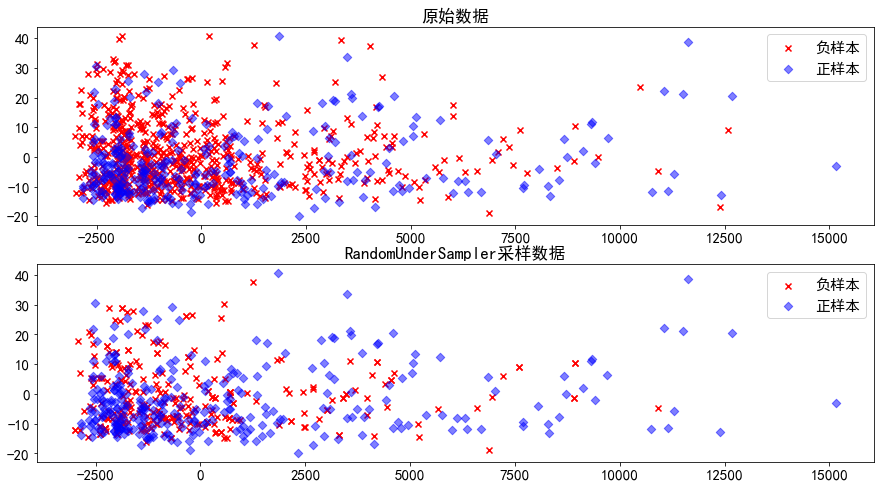

In [4]:
# 针对7个连续变量，进行PCA方法降维
cont_name = ['duration', 'amount', 'income_rate',  'residence_info',  
               'age',  'num_credits','dependents']
x_cont_data = data_df[cont_name]

# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_res[cont_name])

# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#  原始数据降维结果
plt.subplot(211)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# 随机下采样数据降维结果
plt.subplot(212)
index_2 = y_data[rand_under_sample.sample_indices_]==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('RandomUnderSampler采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>2. NearMiss 样本领域选择的下采样方法</font>
由于随机下采样是等概率采样，没有考虑正负样本在分布上的相互影响，如果根据某种策略实现不同区域的采样过程，可以照顾到样本整体的分布情况，效果可能会优于随机下采样，NearMiss 算法正是从这一思想出发。   

NearMiss_1：<font color=red>从正样本的局部范围出发</font> ，选择平均距离较小的负样本，保证异常点不会被纳入建模过程中；   

NearMiss_2：<font color=red>从负样本的全局范围出发</font> ，锁定离正样本平均距离较大的负样本，再从这些负样本中选择样本间距离较小的负样本来建模，这样既可以保障正负样本间距离较大，容易形成分类的超平面，又可以保证选取负样本中典型数据（非异常值），降低过拟合风险，增强模型的泛化能力；  

NearMiss_3：<font color=red>保证正样本与多个负样本关联</font> ，将关联数据集称为一个簇，这些簇距离正样本较近，然后选择这些簇中距离正样本最远的负样本作为下采样，这样可以降低异常点包围正样本的可能性，使模型更容易学习到正负样本之间的规则。<font color=red> 本例效果最优</font> 

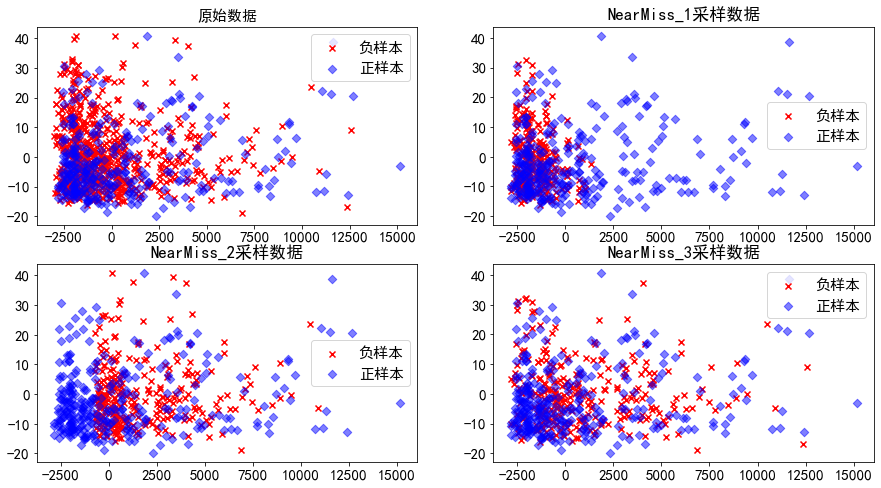

In [5]:
# nearmiss方法
near_miss_1 = NearMiss(version=1,n_neighbors=3) # 最新 imblearn 版本的 NearMiss 没有 random_state、ratio参数
X_resample_1, y_resample_1 = near_miss_1.fit_sample(x_cont_data, y_data)
near_miss_2 = NearMiss(version=2,n_neighbors=3)
X_resample_2, y_resample_2 = near_miss_2.fit_sample(x_cont_data, y_data)
near_miss_3 = NearMiss(version=3,n_neighbors=3)
X_resample_3, y_resample_3 = near_miss_3.fit_sample(x_cont_data, y_data)

# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_resample_1)
X_pca_2 = model_pca.transform(X_resample_2)
X_pca_3 = model_pca.transform(X_resample_3)
    
# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#原始数据降维结果
plt.subplot(221)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始数据',fontsize=fontsize_1)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# NearMiss_1降维结果
plt.subplot(222)
index_2 = y_resample_1==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('NearMiss_1采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# NearMiss_2降维结果
plt.subplot(223)
index_3 = y_resample_2==0
plt.scatter(X_pca_2[index_3, 0], X_pca_2[index_3, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_2[~index_3, 0], X_pca_2[~index_3, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('NearMiss_2采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# NearMiss_3降维结果
plt.subplot(224)
index_4 = y_resample_3==0
plt.scatter(X_pca_3[index_4, 0], X_pca_3[index_4, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_3[~index_4, 0], X_pca_3[~index_4, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('NearMiss_3采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>3. 样本领域清理的下采样：Tomek Links方法</font>
同样是从样本分布规律角度出发，与选择最好区域进而建模不同，领域清理是从<font color=red>剔除易混叠的样本</font>，从而完成下采样。   

Tomek Links 计算每个正样本的最近1个近邻，如果该近邻为负样本，则这两个样本构成一对 Tomek-links，此时的负样本不参与下采样过程（噪音对应将这对正负样本同时删除）。

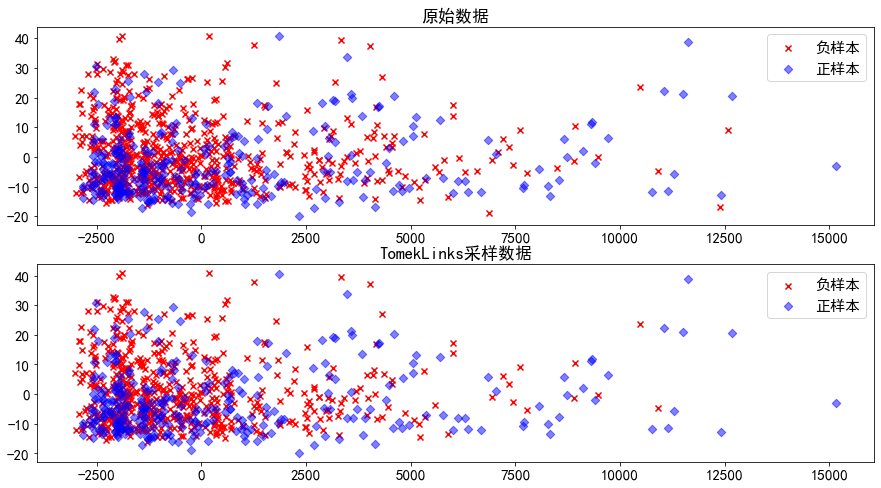

In [6]:
# Tomek Links方法
tom_link = TomekLinks(sampling_strategy='auto') # 最新 imblearn 版本的 TomekLinks 没有 random_state 参数
X_resample, y_resample = tom_link.fit_sample(x_cont_data, y_data)
tom_link.sample_indices_
    
# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_resample)
# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#原始数据降维结果
plt.subplot(211)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend( fontsize=fontsize_1)

#采样数据降维结果
plt.subplot(212)
index_2 = y_resample==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('TomekLinks采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>4. 样本领域清理的下采样：Edited Nearest Neighbour方法</font>
ENN 算法将最近邻样本扩展到3近邻，通过投票的方式来判断该负样本是否应该被删除。   

具体实现：计算每个负样本（多数样本）的3近邻样本，若其中有2个以上为正样本，则该负样本从下采样候选集中被删除。   

弊端：作为多数样本的负样本，其近邻同样为负样本的概率较高，这种方法只能避免一些噪点。

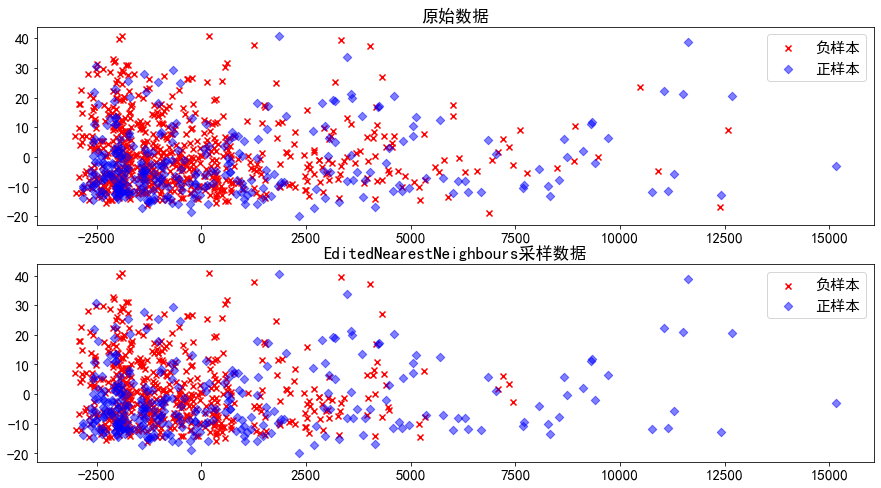

In [7]:
# EditedNearestNeighbours方法
Enn = EditedNearestNeighbours(n_neighbors=3,kind_sel='mode')# 最新 imblearn 版本没有 random_state 参数
X_resample, y_resample = Enn.fit_sample(x_cont_data, y_data)
Enn.sample_indices_
    
# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_resample)

# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

# 原始数据降维结果
plt.subplot(211)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# 采样数据降维结果
plt.subplot(212)
index_2 = y_resample==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('EditedNearestNeighbours采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>5. Bagging集成的下采样方法</font>
Bagging是一种并行的集成学习（Ensemble Learning）框架，其思想是从样本总体中采用自助采样法（有放回采样）得到多个样本子集，对每个样本子集进行建模，再将模型进行融合或叠加，从而得到最终的决策结果。   

<font color=red>步骤说明：</font>
1. 从负样本（多数样本）整体中有放回地抽样出m个负样本子集，每个子集中的负样本量与正样本量相同；  
2. 将正样本分别加入到这 m个负样本子集中，进行模型拟合，形成 m 个模型；
3. 当有新的测试样本输入时，通过 m 个模型投票决定最终分类结果；  
4. 也可以根据 m 个模型在验证集上的表现分配权重，新的测试集样本通过 m 个模型拟合出概率值，再进行加权，求得最终的概率值；
5. 就 m 个模型权重分配方案，可以考虑每个模型在验证集上 AUC 或 KS指标的表现数值，通过归一化得到每个模型的权重；  
6. 如果分类结果希望得到更高的 Recall 召回率，就需要将默认的概率判断阈值（sigmoid函数）从0.5往更小的方向调整，若想提高 Precision 精准率，则将阈值往比0.5更高的方向调整。

<font color=red>由于最新版本的imblearn（scikit-learn-contrib/imbalanced-learn）库，无法加载 Easy Ensemble 算法，故未能完成代码实现。</font>

In [8]:
#  # bagging方法
#  
#  sub_num = math.ceil(sum( data_df.target == 0 ) / sum( data_df.target == 1 ))
#  easy_en = EasyEnsemble(random_state=10,replacement=True,n_estimators=sub_num) 
#  X_resample, y_resample = easy_en.fit_sample(x_cont_data, y_data)
#  X_resample.shape
#  y_resample.shape
#  
#  # PCA降维，到2维
#  model_pca = PCA(n_components=2).fit(x_cont_data)
#  X_pca_raw = model_pca.transform(x_cont_data)
#  X_pca_1 = model_pca.transform(X_resample[0,:,:])
#  X_pca_2 = model_pca.transform(X_resample[1,:,:])
#  X_pca_3 = model_pca.transform(X_resample[2,:,:])
#      
#  # 制图
#  plt.figure(figsize=(15, 8))
#  fontsize_1 = 15
#  
#  #原始数据降维结果
#  plt.subplot(221)
#  index_1 = y_data==0
#  plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
#  plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
#  plt.title('原始数据',fontsize=fontsize_1)
#  plt.xticks( fontsize=fontsize_1)
#  plt.yticks( fontsize=fontsize_1)
#  plt.legend(fontsize=fontsize_1)
#  
#  #sample_1降维结果
#  plt.subplot(222)
#  index_2 =  y_resample[0,:]==0
#  plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
#  plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1],  c='blue',marker='D',alpha=0.5,label='正样本')
#  plt.title('bagging采样1',fontsize=fontsize_1)
#  plt.xticks( fontsize=fontsize_1)
#  plt.yticks( fontsize=fontsize_1)
#  plt.legend(fontsize=fontsize_1)
#  
#  #sample_2降维结果
#  plt.subplot(223)
#  index_3 =  y_resample[1,:]==0
#  plt.scatter(X_pca_2[index_3, 0], X_pca_2[index_3, 1], c='red',marker='x',label='负样本')
#  plt.scatter(X_pca_2[~index_3, 0], X_pca_2[~index_3, 1], c='blue',marker='D',alpha=0.5,label='正样本')
#  plt.title('bagging采样2',fontsize=fontsize_1)
#  plt.xticks( fontsize=fontsize_1)
#  plt.yticks( fontsize=fontsize_1)
#  plt.legend(fontsize=fontsize_1)
#  
#  #Nsample_3降维结果
#  plt.subplot(224)
#  index_4 =  y_resample[2,:]==0
#  plt.scatter(X_pca_3[index_4, 0], X_pca_3[index_4, 1],c='red',marker='x',label='负样本')
#  plt.scatter(X_pca_3[~index_4, 0], X_pca_3[~index_4, 1],  c='blue',marker='D',alpha=0.5,label='正样本')
#  plt.title('bagging采样3',fontsize=fontsize_1)
#  plt.xticks( fontsize=fontsize_1)
#  plt.yticks( fontsize=fontsize_1)
#  plt.legend(fontsize=fontsize_1)

#### <font color=blue>6. Boosting集成的下采样方法</font>
<font color=red>Bagging是并行的集成学习框架，而Boosting是串行的集成学习框架，通过改变样本分布来增加模型的多样性。 </font>  

核心思想：对每次错误分类的样本给予更多重视，在下一轮模型训练时增加权重，从而更好地学习规则，提高正确分类的效果。  

局限与改进：Boosting 框架并没有考虑样本不均衡问题，由于负样本为多数样本，其被错误分类的概率高于正样本，因此，在Boosting的框架下，负样本得到了更多的规则学习，而正样本却没有。这里，我们引入 Balance Cascade方法对样本子集进行均衡处理。   

<font color=red>步骤实现：</font>  
1. 从负样本中随机抽取数量与正样本数相同的负样本子集，与正样本合并成训练集，选择分类模型（如 Logistic逻辑回归、随机森林、AdaBoost等）进行拟合；
2. 用训练得到的模型对负样本整体进行预测，删除被正确分类的样本，将错误分类的样本作为下一次采样的候选集；
3. 在上一轮的候选集中随机抽样，形成新的负样本子集，与正样本合并，再次重复之前的拟合过程，直到剩下的被错误分类的负样本数小于正样本数，停止迭代；
4. 将每一步得到的模型进行叠加，得到最终串行的组合模型。

<font color=red>由于最新版本的imblearn（scikit-learn-contrib/imbalanced-learn）库，无法加载 Balance Cascade 算法，故未能完成代码实现。</font>

In [9]:
#  #boosting方法
#    boost_balance = BalanceCascade(random_state=10,estimator=DecisionTreeClassifier())
#    X_resample, y_resample = boost_balance.fit_resample(x_cont_data, y_data)
#    X_resample.shape
#    y_resample.shape
#    
#    ##PCA降维，到2维
#    model_pca = PCA(n_components=2).fit(x_cont_data)
#    X_pca_raw = model_pca.transform(x_cont_data)
#    X_pca_1 = model_pca.transform(X_resample[0,:,:])
#    X_pca_2 = model_pca.transform(X_resample[1,:,:])
#    X_pca_3 = model_pca.transform(X_resample[2,:,:])
#    
#    ##降维后,用前两维的
#    plt.figure(figsize=(15, 8))
#    fontsize_1 = 15
#    ##原始数据降维结果
#    plt.subplot(221)
#    index_1 = y_data==0
#    plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='grey',marker='o',label='负样本')
#    plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='black',marker='+',alpha=0.5,label='正样本')
#    plt.title('raw_data',fontsize=fontsize_1)
#    plt.xticks( fontsize=fontsize_1)
#    plt.yticks( fontsize=fontsize_1)
#    plt.legend()
#    ##NearMiss_1降维结果
#    plt.subplot(222)
#    index_2 =  y_resample[0,:]==0
#    plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='grey',marker='o',label='负样本')
#    plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1], c='black',marker='+',alpha=0.5,label='正样本')
#    plt.title('sample_1',fontsize=fontsize_1)
#    plt.xticks( fontsize=fontsize_1)
#    plt.yticks( fontsize=fontsize_1)
#    plt.legend()
#    ##NearMiss_2降维结果
#    plt.subplot(223)
#    index_3 =  y_resample[1,:]==0
#    plt.scatter(X_pca_2[index_3, 0], X_pca_2[index_3, 1], c='grey',marker='o',label='负样本')
#    plt.scatter(X_pca_2[~index_3, 0], X_pca_2[~index_3, 1], c='black',marker='+',alpha=0.5,label='正样本')
#    plt.title('sample_2',fontsize=fontsize_1)
#    plt.xticks( fontsize=fontsize_1)
#    plt.yticks( fontsize=fontsize_1)
#    plt.legend()
#    ##NearMiss_3降维结果
#    plt.subplot(224)
#    index_4 =  y_resample[2,:]==0
#    plt.scatter(X_pca_3[index_4, 0], X_pca_3[index_4, 1], c='grey',marker='o',label='负样本')
#    plt.scatter(X_pca_3[~index_4, 0], X_pca_3[~index_4, 1], c='black',marker='+',alpha=0.5,label='正样本')
#    plt.title('sample_3',fontsize=fontsize_1)
#    plt.xticks( fontsize=fontsize_1)
#    plt.yticks( fontsize=fontsize_1)
#    plt.legend()

#### <font color=blue>7. Random Over Sampler随机上采样法</font>
随机上采样是一种无监督的方法，由于等概率地重复采样正样本（少数样本），使得模型容易出现过去局部规则，从而产生过拟合，是采样方法中最坏的策略。

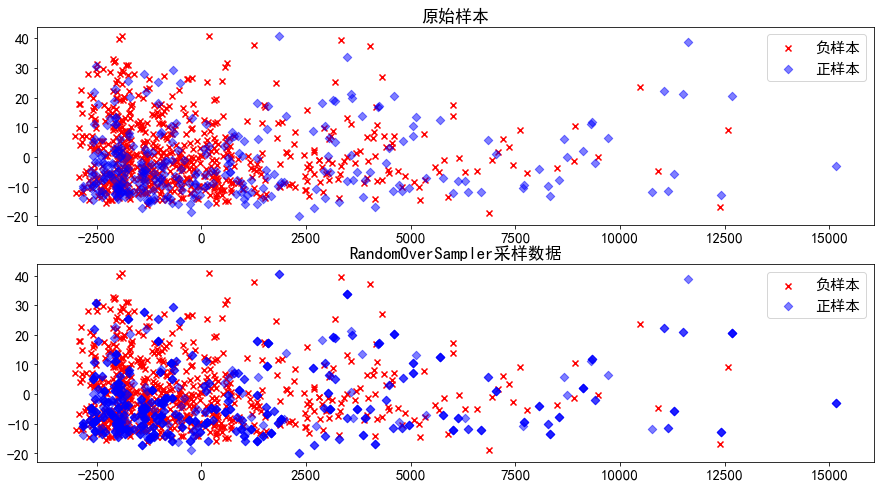

In [10]:
# 随机上采样
rand_over_sample= RandomOverSampler(random_state=10,sampling_strategy=1)
X_resample, y_resample = rand_over_sample.fit_sample(x_data, y_data)
X_res = pd.DataFrame(X_resample,columns=x_data.columns)
X_resample.shape
  
# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_res[cont_name])

# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#原始数据降维结果
plt.subplot(211)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始样本',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#采样数据降维结果
plt.subplot(212)
index_2 = y_resample==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1],c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('RandomOverSampler采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>8. SMOTE样本生成方法</font>
Synthetic Minority Oversampling Technique （SMOTE）也是一种无监督的样本生成法，在考虑到总体样本分布的前提下，在原始样本与其领域样本之间进行随机插值，从而得到上采样的少数样本。  

局限与改进：SMOTE对于离散变量，无法直接进行插值并得到新生成的少数样本。如性别，男为0，女为1，插值生成少数样本0.6是不具有业务意义的。可行的做法是，先对离散变量进行WOE编码/one-hot编码，然后进行SMOTE样本生成，再将得到的变量进行“ 舍入”后，还原为 one-hot编码形式，再进行下一步的模型训练等步骤。  

SMOTE样本生成法，不易形成模型过拟合问题，扩大了少数样本的泛化空间，但缩减了多数样本的表现能力和泛化空间。

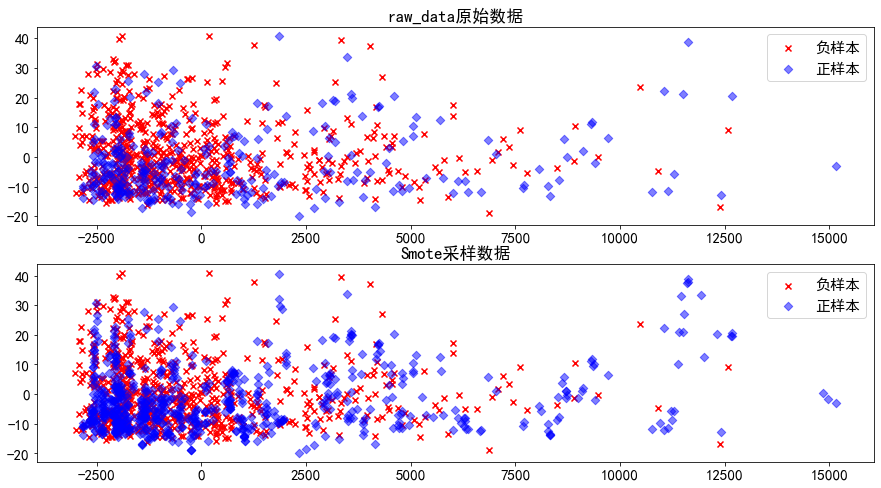

In [11]:
# Smote样本生成方法
sm_sample = SMOTE(random_state=10,sampling_strategy=1,k_neighbors=5) # kind='regular'
X_resample, y_resample = sm_sample.fit_resample(x_cont_data, y_data)
X_resample.shape
    
#PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_resample)

# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#原始数据降维结果
plt.subplot(211)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1],  c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('raw_data原始数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#采样数据降维结果
plt.subplot(212)
index_2 = y_resample==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1],  c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1],c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('Smote采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#### <font color=blue>9. Borderline SMOTE 样本生成法</font>
1. Borderline SMOTE 先根据整个训练集中正负样本比例，确定要生成的少数样本比例 r ，计算每个少数样本的 K 个最邻近样本，构成样本生成领域；
2. 根据整体样本分布中，安全样本、边界样本、噪声样本的判断，找到边界样本；
3. 在边界样本中，采用原始的SMOTE算法生成负样本，完成上采样过程。

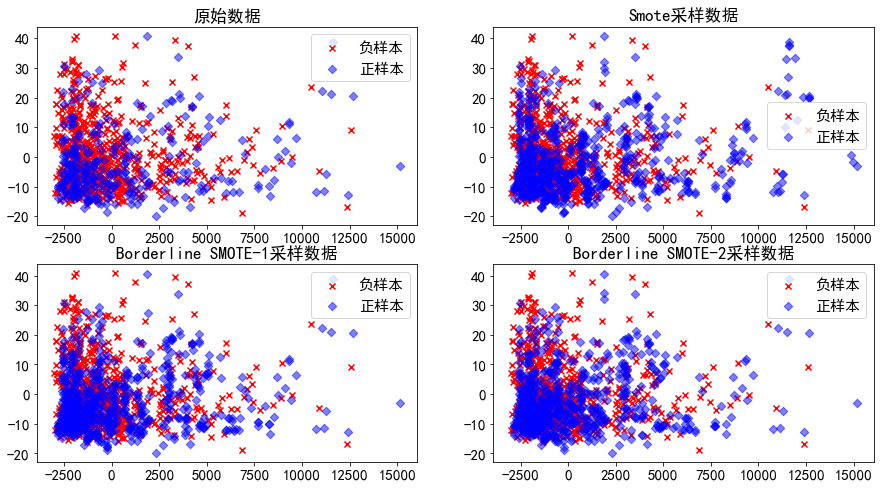

In [12]:
# Borderline SMOTE-1样本生成
sm_sample_1 = BorderlineSMOTE(random_state=10,sampling_strategy=1,k_neighbors=5,kind='borderline-1')
X_resample_1, y_resample_1 = sm_sample_1.fit_resample(x_cont_data, y_data)
X_resample_1.shape

# Borderline SMOTE-2样本生成
sm_sample_2 = BorderlineSMOTE(random_state=10,sampling_strategy=1,k_neighbors=5,kind='borderline-2')
X_resample_2, y_resample_2 = sm_sample_2.fit_resample(x_cont_data, y_data)

# PCA降维，到2维
model_pca = PCA(n_components=2).fit(x_cont_data)
X_pca_raw = model_pca.transform(x_cont_data)
X_pca_1 = model_pca.transform(X_resample)
X_pca_2 = model_pca.transform(X_resample_1)
X_pca_3 = model_pca.transform(X_resample_2)
    
# 制图
plt.figure(figsize=(15, 8))
fontsize_1 = 15

#原始数据降维结果
plt.subplot(221)
index_1 = y_data==0
plt.scatter(X_pca_raw[index_1, 0], X_pca_raw[index_1, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_raw[~index_1, 0], X_pca_raw[~index_1, 1], c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('原始数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

#采样数据降维结果
plt.subplot(222)
index_2 = y_resample==0
plt.scatter(X_pca_1[index_2, 0], X_pca_1[index_2, 1],c='red',marker='x',label='负样本')
plt.scatter(X_pca_1[~index_2, 0], X_pca_1[~index_2, 1],c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('Smote采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# Borderline SMOTE-1降维结果
plt.subplot(223)
index_3 =  y_resample_1==0
plt.scatter(X_pca_2[index_3, 0], X_pca_2[index_3, 1], c='red',marker='x',label='负样本')
plt.scatter(X_pca_2[~index_3, 0], X_pca_2[~index_3, 1],c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('Borderline SMOTE-1采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)

# Borderline SMOTE-2降维结果
plt.subplot(224)
index_4 =  y_resample_2==0
plt.scatter(X_pca_3[index_4, 0], X_pca_3[index_4, 1],c='red',marker='x',label='负样本')
plt.scatter(X_pca_3[~index_4, 0], X_pca_3[~index_4, 1],c='blue',marker='D',alpha=0.5,label='正样本')
plt.title('Borderline SMOTE-2采样数据',fontsize=17)
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)